# Pre-processamento com SMOTE

# **Parte 1 - Introdução**

Este notebook tem como objetivo desenvolver e avaliar um modelo preditivo de inadimplência utilizando técnicas de balanceamento de classes, especificamente o método **SMOTE (Synthetic Minority Over-sampling Technique)**.

Na etapa anterior do projeto, foi realizada uma Análise Exploratória de Dados (EDA), na qual foi identificado um forte desbalanceamento na variável alvo `over30_mob3`, com aproximadamente 87% dos clientes classificados como adimplentes (classe 0) e apenas 13% como inadimplentes (classe 1). Esse cenário é comum em problemas de risco de crédito, porém pode comprometer o desempenho dos modelos de classificação, que tendem a favorecer a classe majoritária.

Diante disso, este notebook foca na construção de um pipeline de modelagem que:

* Realiza o pré-processamento dos dados para uso em modelos de Machine Learning;
* Aplica o SMOTE exclusivamente no conjunto de treino, evitando vazamento de informação (data leakage);
* Treina um modelo de classificação (Regressão Logística) com dados balanceados;
* Avalia o desempenho do modelo por meio de métricas adequadas ao problema, como Recall da classe inadimplente, AUC-ROC, matriz de confusão e F1-score;
* Analisa a capacidade do modelo em identificar clientes com maior risco de inadimplência no momento da admissão de crédito.

O objetivo final é construir um modelo simples, interpretável e eficaz para apoiar a tomada de decisão no processo de concessão de crédito, reduzindo a aprovação de clientes com alta probabilidade de atraso superior a 30 dias.

# Parte 2 - Database

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [2]:
# Base dados
file_path = r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\Case_tecnico_Koin\input\Cargos_salarios_CPNU2_ (1).xlsx"

df = pd.read_excel(file_path, sheet_name="Base_Dados")
df

,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
0,202212,1,2022-12-30,17,1,1085.87,121 - 150 dias,0,Baixo Risco,hotmail,33.0,1,0,0,SP,1600.0,NaN,309.0
1,202303,2,2023-03-03,15,1,1686.34,16 - 30 dias,0,Baixo Risco,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0
2,202302,3,2023-02-02,19,1,2807.66,241 - 270 dias,0,Baixo Risco,terra,28.0,1,0,0,SP,1700.0,82.0,514.0
3,202303,5,2023-03-27,16,1,333.92,16 - 30 dias,1,Baixo Risco,gmail,53.0,1,0,0,PR,2950.0,50.0,441.0
4,202303,7,2023-03-06,23,1,2721.98,61 - 90 dias,0,Baixo Risco,hotmail,34.0,1,1,1,BA,3650.0,190.0,474.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32837,202303,32766,2023-03-24,13,2,6431.54,181 - 210 dias,0,Medio Risco,gmail,28.0,1,1,0,AC,4250.0,5.0,341.0
32838,202211,32780,2022-11-19,10,2,1702.78,46 - 60 dias,1,Baixo Risco,yahoo,33.0,1,0,0,SP,1500.0,137.0,290.0
32839,202212,32793,2022-12-10,1,2,6515.57,91 - 120 dias,0,Baixo Risco,hotmail,39.0,1,1,0,MG,7150.0,90.0,527.0
32840,202301,32804,2023-01-29,21,2,1320.00,16 - 30 dias,0,Baixo Risco,gmail,34.0,1,0,0,SP,3700.0,79.0,483.0


In [3]:
df.head()

,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
0,202212,1,2022-12-30,17,1,1085.87,121 - 150 dias,0,Baixo Risco,hotmail,33.0,1,0,0,SP,1600.0,NaN,309.0
1,202303,2,2023-03-03,15,1,1686.34,16 - 30 dias,0,Baixo Risco,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0
2,202302,3,2023-02-02,19,1,2807.66,241 - 270 dias,0,Baixo Risco,terra,28.0,1,0,0,SP,1700.0,82.0,514.0
3,202303,5,2023-03-27,16,1,333.92,16 - 30 dias,1,Baixo Risco,gmail,53.0,1,0,0,PR,2950.0,50.0,441.0
4,202303,7,2023-03-06,23,1,2721.98,61 - 90 dias,0,Baixo Risco,hotmail,34.0,1,1,1,BA,3650.0,190.0,474.0


In [4]:
df.tail()

,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
32837,202303,32766,2023-03-24,13,2,6431.54,181 - 210 dias,0,Medio Risco,gmail,28.0,1,1,0,AC,4250.0,5.0,341.0
32838,202211,32780,2022-11-19,10,2,1702.78,46 - 60 dias,1,Baixo Risco,yahoo,33.0,1,0,0,SP,1500.0,137.0,290.0
32839,202212,32793,2022-12-10,1,2,6515.57,91 - 120 dias,0,Baixo Risco,hotmail,39.0,1,1,0,MG,7150.0,90.0,527.0
32840,202301,32804,2023-01-29,21,2,1320.00,16 - 30 dias,0,Baixo Risco,gmail,34.0,1,0,0,SP,3700.0,79.0,483.0
32841,202302,32826,2023-02-02,7,2,1741.96,121 - 150 dias,0,Medio Risco,hotmail,36.0,1,0,0,DF,4350.0,50.0,434.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32842 entries, 0 to 32841
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   safra                 32842 non-null  int64         
 1   id_trx                32842 non-null  int64         
 2   Data compra           32842 non-null  datetime64[ns]
 3   Hora da compra        32842 non-null  int64         
 4   Tipo de cliente       32842 non-null  int64         
 5   valor_compra          32842 non-null  float64       
 6   Tempo até utilização  32842 non-null  object        
 7   over30_mob3           32842 non-null  int64         
 8   risco_validador       32842 non-null  object        
 9   provedor_email        32665 non-null  object        
 10  idade_cliente         32797 non-null  float64       
 11  Produto_1             32842 non-null  int64         
 12  Produto_2             32842 non-null  int64         
 13  Produto_3       

In [6]:
df.shape

(32842, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32842 entries, 0 to 32841
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   safra                 32842 non-null  int64         
 1   id_trx                32842 non-null  int64         
 2   Data compra           32842 non-null  datetime64[ns]
 3   Hora da compra        32842 non-null  int64         
 4   Tipo de cliente       32842 non-null  int64         
 5   valor_compra          32842 non-null  float64       
 6   Tempo até utilização  32842 non-null  object        
 7   over30_mob3           32842 non-null  int64         
 8   risco_validador       32842 non-null  object        
 9   provedor_email        32665 non-null  object        
 10  idade_cliente         32797 non-null  float64       
 11  Produto_1             32842 non-null  int64         
 12  Produto_2             32842 non-null  int64         
 13  Produto_3       

In [8]:
df.dtypes

safra                            int64
id_trx                           int64
Data compra             datetime64[ns]
Hora da compra                   int64
Tipo de cliente                  int64
valor_compra                   float64
Tempo até utilização            object
over30_mob3                      int64
risco_validador                 object
provedor_email                  object
idade_cliente                  float64
Produto_1                        int64
Produto_2                        int64
Produto_3                        int64
uf                              object
Renda                          float64
Score Email                    float64
Score Pessoa                   float64
dtype: object

# Parte 3 - Pre-processamento

In [ ]:
# Padronização dos nomes das colunas (minúsculas, sem espaços e sem acentos)
df.columns = (
    df.columns.str.lower()
    .str.replace(" ", "_")
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

# Remoção de registros duplicados com base no id da transação
df = df.drop_duplicates(subset="id_trx")

# Conversão da coluna de data para formato datetime
df["data_compra"] = pd.to_datetime(df["data_compra"], errors="coerce")

# Conversão da hora da compra para valor numérico (hora)
df["hora_da_compra"] = pd.to_datetime(df["hora_da_compra"], errors="coerce").dt.hour

# Lista de colunas numéricas
num_cols = [
    "valor_compra",
    "tempo_ate_utilizacao",
    "idade_cliente",
    "renda",
    "score_email",
    "score_pessoa"
]

# Conversão das colunas numéricas para tipo numérico
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Conversão da variável alvo para inteiro
df["over30_mob3"] = df["over30_mob3"].astype("Int64")

# Tratamento de valores ausentes nas colunas numéricas usando a mediana
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Lista de colunas categóricas
cat_cols = [
    "tipo_de_cliente",
    "risco_validador",
    "provedor_email",
    "produto_1",
    "produto_2",
    "produto_3",
    "uf"
]

# Tratamento de valores ausentes nas colunas categóricas
for col in cat_cols:
    df[col] = df[col].fillna("Desconhecido")

# Garantir que a variável alvo contenha apenas valores 0 ou 1
df = df[df["over30_mob3"].isin([0, 1])]

# Criação da variável dia da semana a partir da data da compra
df["dia_semana"] = df["data_compra"].dt.day_name()

# Visualização inicial do dataset tratado
df.head()

,safra,id_trx,data_compra,hora_da_compra,tipo_de_cliente,valor_compra,tempo_ate_utilizacao,over30_mob3,risco_validador,provedor_email,idade_cliente,produto_1,produto_2,produto_3,uf,renda,score_email,score_pessoa,dia_semana
0,202212,1,2022-12-30,0,1,1085.87,NaN,0,Baixo Risco,hotmail,33.0,1,0,0,SP,1600.0,82.0,309.0,Friday
1,202303,2,2023-03-03,0,1,1686.34,NaN,0,Baixo Risco,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0,Friday
2,202302,3,2023-02-02,0,1,2807.66,NaN,0,Baixo Risco,terra,28.0,1,0,0,SP,1700.0,82.0,514.0,Thursday
3,202303,5,2023-03-27,0,1,333.92,NaN,1,Baixo Risco,gmail,53.0,1,0,0,PR,2950.0,50.0,441.0,Monday
4,202303,7,2023-03-06,0,1,2721.98,NaN,0,Baixo Risco,hotmail,34.0,1,1,1,BA,3650.0,190.0,474.0,Monday


# **Parte 4 - Limpeza de dados**

In [10]:
# Ver quantidade de valores nulos por coluna
null_counts = df.isnull().sum()

# Criar tabela com quantidade e percentual de nulos
null_table = pd.DataFrame({
    "Qtd_Nulos": null_counts,
    "Percentual_%": (null_counts / len(df)) * 100
}).sort_values(by="Percentual_%", ascending=False)

# Remover a coluna que possui 100% de valores nulos
df = df.drop(columns=["tempo_ate_utilizacao"])

# Lista de colunas numéricas
num_cols = [
    "valor_compra",
    "idade_cliente",
    "renda",
    "score_email",
    "score_pessoa"
]

# Imputação dos valores nulos usando a média
for col in num_cols:
    media = df[col].mean()
    df[col] = df[col].fillna(media)

# Verificar se ainda existem valores nulos
df.isnull().sum()

safra              0
id_trx             0
data_compra        0
hora_da_compra     0
tipo_de_cliente    0
valor_compra       0
over30_mob3        0
risco_validador    0
provedor_email     0
idade_cliente      0
produto_1          0
produto_2          0
produto_3          0
uf                 0
renda              0
score_email        0
score_pessoa       0
dia_semana         0
dtype: int64

In [11]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

df.isnull().sum()

safra              0
id_trx             0
data_compra        0
hora_da_compra     0
tipo_de_cliente    0
valor_compra       0
over30_mob3        0
risco_validador    0
provedor_email     0
idade_cliente      0
produto_1          0
produto_2          0
produto_3          0
uf                 0
renda              0
score_email        0
score_pessoa       0
dia_semana         0
dtype: int64

In [12]:
# Salvando o dataset
df.to_excel(
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\Case_tecnico_Koin\data\dataset_limpo.xlsx",
    index=False
)

df.to_csv(
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\Case_tecnico_Koin\data\dataset_limpo.csv",
    index=False
)

# **Parte 5 - Feature Engineering (LabelEncoderEncoding)**

In [14]:
# Identificar colunas categóricas
cat_cols = df.select_dtypes(include=["object", "bool"]).columns
cat_cols

Index(['risco_validador', 'provedor_email', 'uf', 'dia_semana'], dtype='object')

In [17]:
#
df_le = df.copy()

#
le = LabelEncoder()

#
for col in cat_cols:
    df_le[col] = le.fit_transform(df_le[col].astype(str))

df_le.dtypes

safra                       int64
id_trx                      int64
data_compra        datetime64[ns]
hora_da_compra              int32
tipo_de_cliente             int64
valor_compra              float64
over30_mob3                 Int64
risco_validador             int32
provedor_email              int32
idade_cliente             float64
produto_1                   int64
produto_2                   int64
produto_3                   int64
uf                          int32
renda                     float64
score_email               float64
score_pessoa              float64
dia_semana                  int32
dtype: object

In [18]:
df_le

,safra,id_trx,data_compra,hora_da_compra,tipo_de_cliente,valor_compra,over30_mob3,risco_validador,provedor_email,idade_cliente,produto_1,produto_2,produto_3,uf,renda,score_email,score_pessoa,dia_semana
0,202212,1,2022-12-30,0,1,1085.87,0,1,297,33.0,1,0,0,26,1600.0,82.0,309.0,0
1,202303,2,2023-03-03,0,1,1686.34,0,1,297,34.0,1,0,0,26,4250.0,85.0,322.0,0
2,202302,3,2023-02-02,0,1,2807.66,0,1,635,28.0,1,0,0,26,1700.0,82.0,514.0,4
3,202303,5,2023-03-27,0,1,333.92,1,1,255,53.0,1,0,0,18,2950.0,50.0,441.0,1
4,202303,7,2023-03-06,0,1,2721.98,0,1,297,34.0,1,1,1,4,3650.0,190.0,474.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32837,202303,32766,2023-03-24,0,2,6431.54,0,2,255,28.0,1,1,0,0,4250.0,5.0,341.0,0
32838,202211,32780,2022-11-19,0,2,1702.78,1,1,726,33.0,1,0,0,26,1500.0,137.0,290.0,2
32839,202212,32793,2022-12-10,0,2,6515.57,0,1,297,39.0,1,1,0,11,7150.0,90.0,527.0,2
32840,202301,32804,2023-01-29,0,2,1320.00,0,1,255,34.0,1,0,0,26,3700.0,79.0,483.0,3


# **Parte 6 - Features x y**

In [19]:
X = df_le.drop(columns=["over30_mob3"])
y = df_le["over30_mob3"]

# Remover colunas que não devem entrar no modelo/SMOTE
cols_to_drop = ["data_compra", "id_trx", "hora_da_compra"]

X_model = X.drop(columns=[c for c in cols_to_drop if c in X.columns])

# **Parte 7 - SMOTE**

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_model, y)

print("Antes do SMOTE:")
print(y.value_counts())

print("Depois do SMOTE:")
print(pd.Series(y_res).value_counts())

smote

Antes do SMOTE:
over30_mob3
0    28687
1     4155
Name: count, dtype: Int64
Depois do SMOTE:
over30_mob3
0    28687
1    28687
Name: count, dtype: Int64


SMOTE(random_state=42)

In [25]:
# DataFrame final balanceado
df_smote_le = pd.DataFrame(X_res, columns=X_model.columns)
df_smote_le["over30_mob3"] = y_res
df_smote_le.head()

,safra,tipo_de_cliente,valor_compra,risco_validador,provedor_email,idade_cliente,produto_1,produto_2,produto_3,uf,renda,score_email,score_pessoa,dia_semana,over30_mob3
0,202212,1,1085.87,1,297,33.0,1,0,0,26,1600.0,82.0,309.0,0,0
1,202303,1,1686.34,1,297,34.0,1,0,0,26,4250.0,85.0,322.0,0,0
2,202302,1,2807.66,1,635,28.0,1,0,0,26,1700.0,82.0,514.0,4,0
3,202303,1,333.92,1,255,53.0,1,0,0,18,2950.0,50.0,441.0,1,1
4,202303,1,2721.98,1,297,34.0,1,1,1,4,3650.0,190.0,474.0,1,0


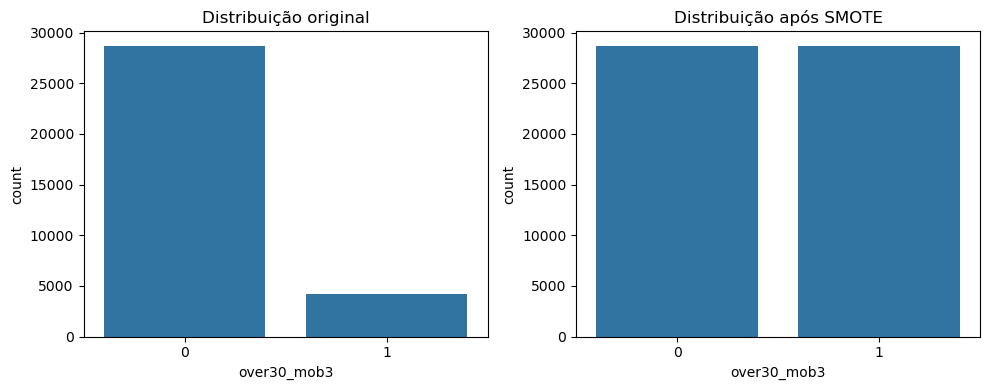

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(x=y, ax=ax[0])
ax[0].set_title("Distribuição original")

sns.countplot(x=y_res, ax=ax[1])
ax[1].set_title("Distribuição após SMOTE")

plt.tight_layout()
plt.show()

**Análise**

O gráfico mostra claramente:

**Distribuição original:**

* Forte desbalanceamento entre as classes
* Classe 0 (adimplente) é muito maior que a classe 1 (inadimplente)
* Isso poderia gerar um modelo enviesado para prever sempre “0”

**Distribuição após SMOTE:**

* As duas classes ficaram balanceadas (0 ≈ 1)
* Agora o modelo terá exemplos suficientes de clientes inadimplentes para aprender padrões de risco
* O dataset está adequado para treinamento de modelos de classificação

Ou seja: dataset limpo + SMOTE foi aplicado corretamente


> Observa-se que a base original apresenta forte desbalanceamento da variável alvo `over30_mob3`, com predominância de clientes adimplentes.
>
> Após a aplicação do SMOTE, as classes foram balanceadas, permitindo um treinamento mais justo dos modelos de classificação e reduzindo o viés na predição de clientes inadimplentes.

In [26]:
# Salvar CSV
df_smote_le.to_csv(
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\Case_tecnico_Koin\data\dataset_smote_labelencoder.csv",
    index=False
)

df_smote_le.to_excel(
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\Case_tecnico_Koin\data\dataset_smote_labelencoder.xlsx",
    index=False
)